In [1]:
# Enable outputting results interactively. 
# All the results from code in a given cell will be displayed instead of only the last one.


In [2]:
#EDA and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
import seaborn as sns
from pywaffle import Waffle
%matplotlib inline
%run 'src/EDA.py'
%run 'src/prophet.py'

#time series predictions
from fbprophet import Prophet
import logging
from sklearn.metrics import mean_squared_error

#DBSCAN
from sklearn.cluster import DBSCAN
import folium
from sklearn.preprocessing import StandardScaler
import sklearn.utils



In [108]:
df = pd.read_csv('data/boston-15-19.csv')

In [109]:
df.head(3)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0      I192056106           562      Other Burglary   
1      I192056104          3115  Investigate Person   
2      I192056102          3301     Verbal Disputes   

           OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0  BURGLARY - OTHER - NO FORCE       C6            186      NaN   
1           INVESTIGATE PERSON      C11            342      NaN   
2               VERBAL DISPUTE      C11            373      NaN   

      OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0  2019-07-20 21:49:00  2019      7    Saturday    21    Part One   
1  2019-07-20 20:07:00  2019      7    Saturday    20  Part Three   
2  2019-07-20 20:43:00  2019      7    Saturday    20  Part Three   

              STREET        Lat       Long                     Location  
0  MASSACHUSETTS AVE  42.325538 -71.065796  (42.32553801, -71.06579592)  
1         GENEVA AVE  42.301351 -71.067965  (42.30135087, -71.06796465)  
2       SOUTHWICK ST  42.291436 -71.049098  (42.29143617, -71.04909809)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405254 entries, 0 to 405253
Data columns (total 17 columns):
INCIDENT_NUMBER        405254 non-null object
OFFENSE_CODE           405254 non-null int64
OFFENSE_CODE_GROUP     405254 non-null object
OFFENSE_DESCRIPTION    405254 non-null object
DISTRICT               403111 non-null object
REPORTING_AREA         405254 non-null object
SHOOTING               1653 non-null object
OCCURRED_ON_DATE       405254 non-null object
YEAR                   405254 non-null int64
MONTH                  405254 non-null int64
DAY_OF_WEEK            405254 non-null object
HOUR                   405254 non-null int64
UCR_PART               405146 non-null object
STREET                 393213 non-null object
Lat                    379698 non-null float64
Long                   379698 non-null float64
Location               405254 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 52.6+ MB


### Boston Crime Analysis

In [129]:
df['monthalpha'] = df['MONTH'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}, inplace=True)





In [112]:
# extract date from OCCURRED ON DATE and create date column
df['date'] = df['OCCURRED_ON_DATE'].apply(lambda x: date_split(x))

In [113]:
# extract time from OCCURRED ON DATE and create time column
df['time'] = df['OCCURRED_ON_DATE'].apply(lambda x: time_split(x))

In [114]:
df[['date','time']].head(3)

date      time
0  2019-07-20  21:49:00
1  2019-07-20  20:07:00
2  2019-07-20  20:43:00

In [115]:
print(min(df['date']))
print(max(df['date']))

2015-06-15
2019-07-20


In [150]:
start_date = '2015-07-01'
end_date = '2019-06-30'
mask = (df['date'] >= datetime.strptime(start_date, '%Y-%m-%d').date()) & (df['date'] <= datetime.strptime(end_date, '%Y-%m-%d').date())
df = df[mask]
print(min(df['date']), max(df['date']))

2015-07-01 2019-06-30


In [130]:
df.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location', 'date', 'time', 'monthalpha'],
      dtype='object')

In [106]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [128]:
month = pd.DataFrame(df.groupby('MONTH')['INCIDENT_NUMBER'].agg('count')).reset_index().sort_values(by='MONTH')


In [127]:
plt.figure(figsize = (10, 5))
ax = month.plot(kind='bar', x=month.MONTH, figsize=(14,8), title='Counts of Incidents by Month')
# plt.title('Counts of Incidents by Month',size=15)
plt.tight_layout()
plt.savefig('img/incidents_month.png')

KeyError: "None of [Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')] are in the [columns]"

<Figure size 720x360 with 0 Axes>

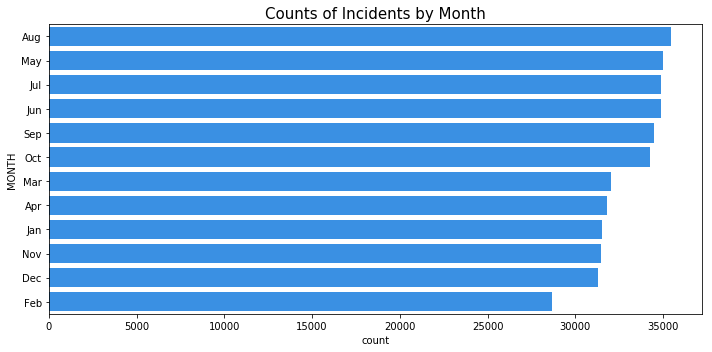

In [220]:
plt.figure(figsize = (10,5))
sns.countplot(y='MONTH',color='dodgerblue',  data=df, order=df['MONTH'].value_counts().iloc[:12].index)
plt.title('Counts of Incidents by Month',size=15)
plt.tight_layout()
plt.savefig('img/incidents_month.png')

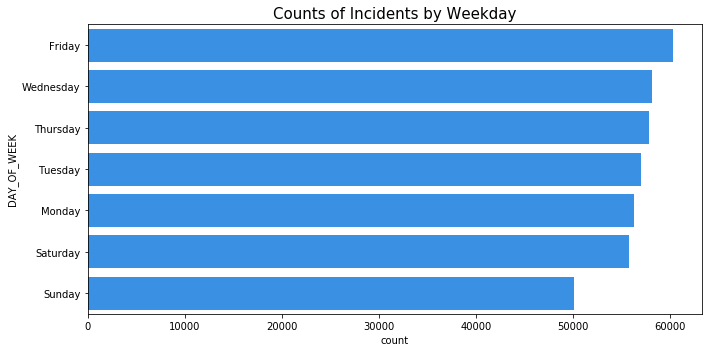

In [84]:
plt.figure(figsize = (10,5))
sns.countplot(y='DAY_OF_WEEK',color='dodgerblue',  data=df, order=df['DAY_OF_WEEK'].value_counts().iloc[:7].index)
plt.title('Counts of Incidents by Weekday',size=15)
plt.tight_layout()
plt.savefig('img/incidents_weekday.png')

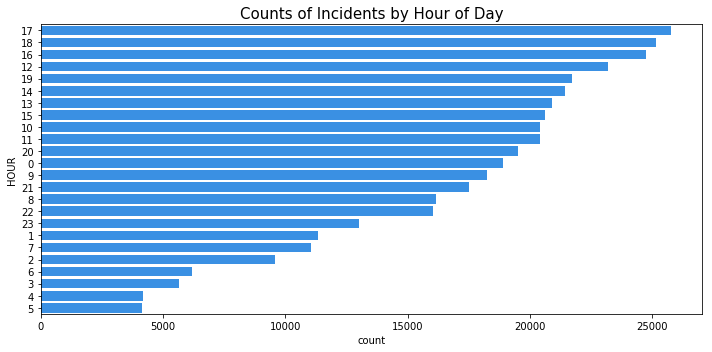

In [85]:
plt.figure(figsize = (10,5))
sns.countplot(y='HOUR', data=df, color='dodgerblue', order=df['HOUR'].value_counts().iloc[:24].index)
plt.title('Counts of Incidents by Hour of Day',size=15)
plt.tight_layout()
plt.savefig('img/incidents_hour.png')

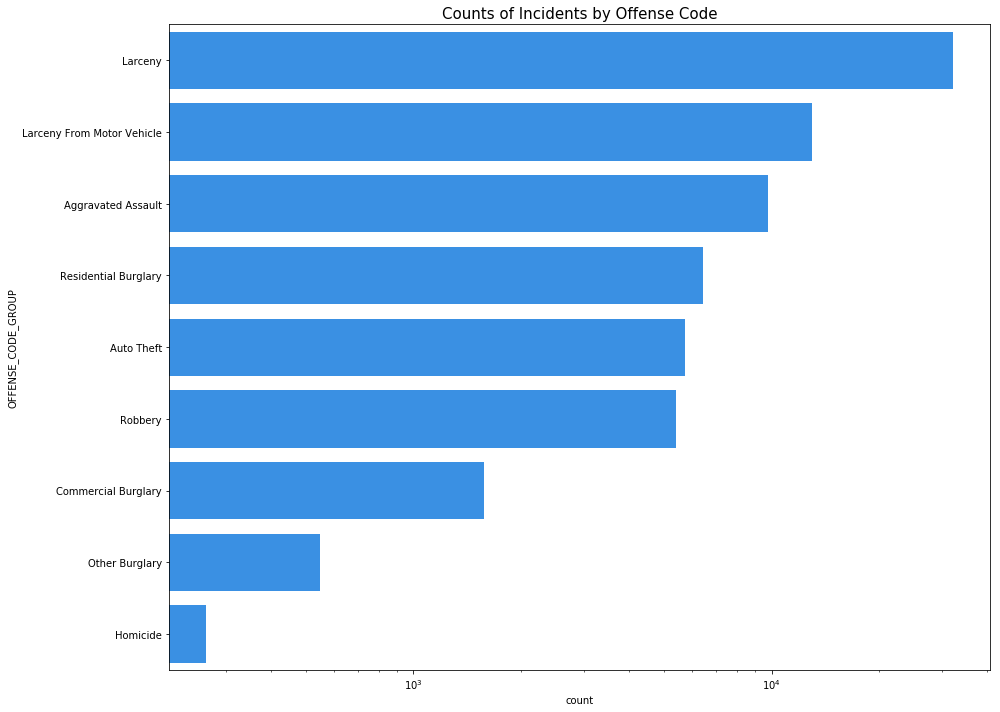

In [132]:
plt.figure(figsize = (14,10))
sns.countplot(y='OFFENSE_CODE_GROUP',color='dodgerblue',  data=df, order=df[df['UCR_PART'] == 'Part One']['OFFENSE_CODE_GROUP'].value_counts().iloc[:100].index)
plt.title('Counts of Incidents by Offense Code',size=15)
# plt.yticks(size=12)
plt.xscale('log')
plt.tight_layout()
plt.savefig('img/incidents_offense_code_p1.png')

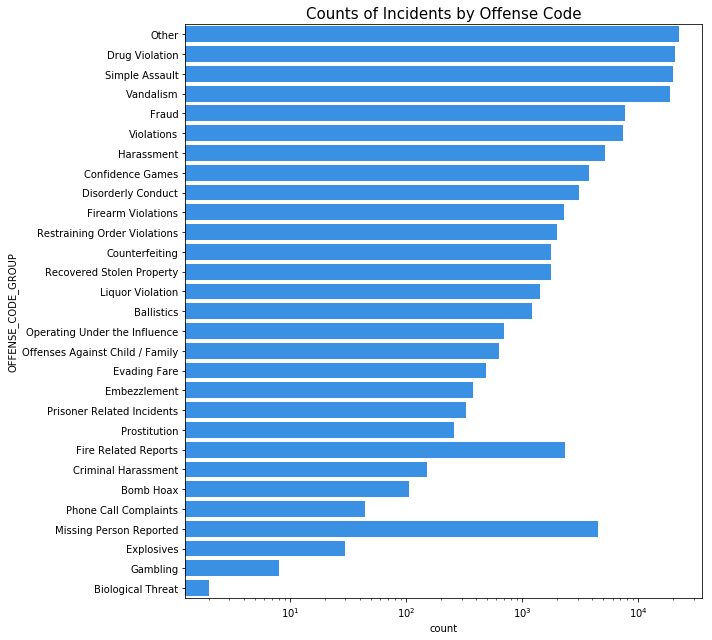

In [87]:
plt.figure(figsize = (10,9))
sns.countplot(y='OFFENSE_CODE_GROUP', data=df,color='dodgerblue',  order=df[df['UCR_PART'] == 'Part Two']['OFFENSE_CODE_GROUP'].value_counts().iloc[:100].index)
plt.title('Counts of Incidents by Offense Code',size=15)
plt.xscale('log')
plt.tight_layout()
plt.savefig('img/incidents_offense_code_p2.png')

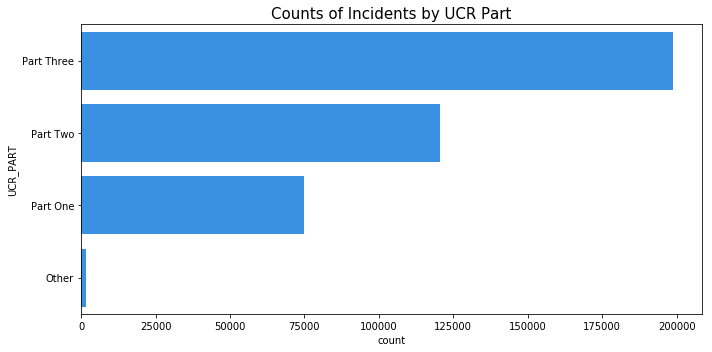

In [183]:
plt.figure(figsize = (10,5))
sns.countplot(y='UCR_PART', data=df, color='dodgerblue', order=df['UCR_PART'].value_counts().iloc[:8].index)
plt.title('Counts of Incidents by UCR Part',size=15)
plt.tight_layout()
plt.savefig('img/incidents_UCR.png')

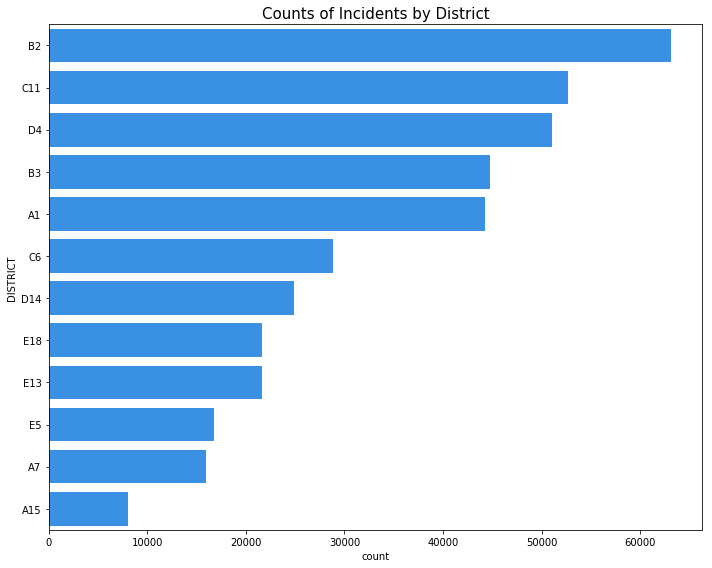

In [144]:
plt.figure(figsize=(10, 8))
sns.countplot(y='DISTRICT', data=df, color='dodgerblue', order=df['DISTRICT'].value_counts().iloc[:].index)
plt.title('Counts of Incidents by District',size=15)
plt.tight_layout()
plt.savefig('img/incidents_district.png')

In [151]:
min(df.Long)

nan

In [147]:
a = df.pivot_table(index='Lat',
                   columns='Long',
                   values='INCIDENT_NUMBER')

DataError: No numeric types to aggregate

In [18]:
waffle = pd.DataFrame(df.DISTRICT.value_counts())
waffle.reset_index(inplace=True)

In [19]:
waffle.columns = ['district', 'count']
waffle

district  count
0        B2  63108
1       C11  52684
2        D4  51091
3        B3  44729
4        A1  44201
5        C6  28811
6       D14  24886
7       E18  21688
8       E13  21653
9        E5  16811
10       A7  15960
11      A15   8077

In [20]:
# # waffledistrict
# fig = plt.figure(
#     FigureClass=Waffle,
#     rows=12,
#     values= list(waffle['count']),
#     labels= list(waffle['district']))


In [29]:
dailydf = df[['date', 'INCIDENT_NUMBER']].groupby('date').count()
dailydf.reset_index(inplace=True)
dailydf.columns = ['ds', 'y']

In [30]:
dailydf.head()

ds    y
0  2015-07-01  289
1  2015-07-02  272
2  2015-07-03  270
3  2015-07-04  254
4  2015-07-05  248

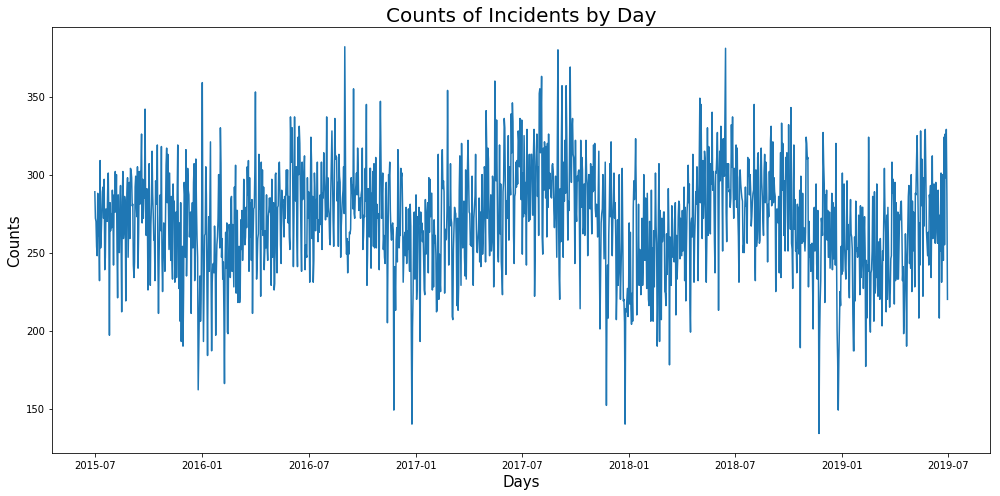

In [41]:
plt.figure(figsize=(14,7))
sns.lineplot(x='ds',y='y',data=dailydf)
plt.title('Counts of Incidents by Day',size=20)
plt.xlabel('Days', size=15)
plt.ylabel('Counts', size=15)
plt.tight_layout()
plt.savefig('img/day_counts.png')

In [24]:
df.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location', 'date', 'time'],
      dtype='object')

In [43]:
aggdf = df.set_index('date').groupby('date')[['INCIDENT_NUMBER']].count()

In [44]:
aggdf.reset_index(inplace=True)

In [45]:
aggdf.columns = ['date', 'count']

In [46]:
weeklydf = aggdf.set_index(pd.DatetimeIndex(aggdf['date']))

In [47]:
weeklydf = weeklydf.resample('W').apply(sum)

In [48]:
weeklydf.reset_index(inplace=True)

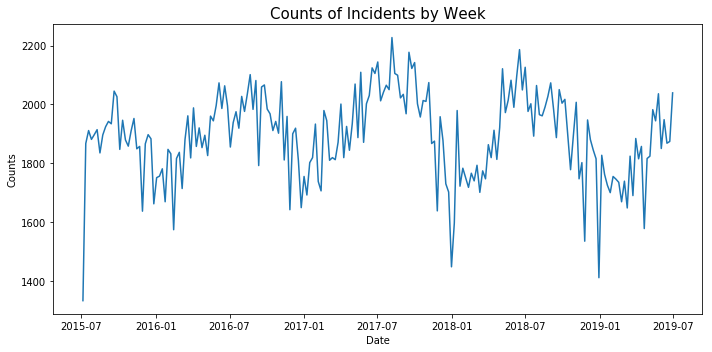

In [51]:
plt.figure(figsize=(10,5))
sns.lineplot(x='date',y='count',data=weeklydf)
plt.title('Counts of Incidents by Week',size=15)
plt.xlabel('Date')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig('img/week_counts.png')

In [52]:
monthlydf = df.set_index(pd.DatetimeIndex(df['date']))
monthlydf = pd.DataFrame(monthlydf.resample('M').count())
monthlydf = monthlydf.drop(['date'], axis=1)
monthlydf.reset_index(inplace=True)
monthlydf = monthlydf[['date', 'INCIDENT_NUMBER']]
monthlydf.columns = ['month_of', 'count']
monthlydf.head()

month_of  count
0 2015-07-31   8369
1 2015-08-31   8393
2 2015-09-30   8432
3 2015-10-31   8334
4 2015-11-30   7838

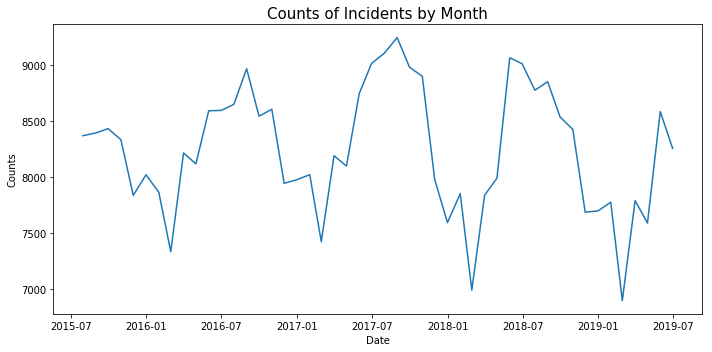

In [53]:
plt.figure(figsize=(10,5))
sns.lineplot(x='month_of',y='count',data=monthlydf)
plt.title('Counts of Incidents by Month',size=15)
plt.xlabel('Date')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig('img/month_counts.png')

## Baseline Model - Persistence Algorithm (the 'naive' forecast)

In [205]:
dailydf.to_csv('data/trainbase.csv')

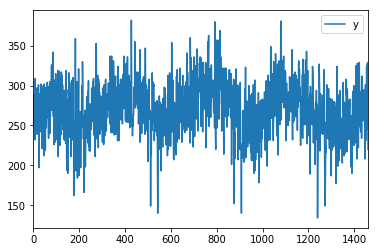

In [206]:
series = pd.read_csv('data/trainbase.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series.plot()
plt.show()

In [207]:
values.head(1)

0    1
0  2015-07-01  289

In [204]:
pd.concat([values.shift(1), values], axis=1).head()


0    1           0    1
0         NaN  NaN  2015-07-01  289
1  2015-07-01  289  2015-07-02  272
2  2015-07-02  272  2015-07-03  270
3  2015-07-03  270  2015-07-04  254
4  2015-07-04  254  2015-07-05  248

In [211]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['trash', 't-1', 'date', 't+1']
dataframe.head()

trash  t-1        date  t+1
0         NaN  NaN  2015-07-01  289
1  2015-07-01  289  2015-07-02  272
2  2015-07-02  272  2015-07-03  270
3  2015-07-03  270  2015-07-04  254
4  2015-07-04  254  2015-07-05  248

In [213]:
# dataframe.drop('trash', axis=1, inplace=True)
dataframe = dataframe[1:]
dataframe.head()

t-1        date  t+1
1  289  2015-07-02  272
2  272  2015-07-03  270
3  270  2015-07-04  254
4  254  2015-07-05  248
5  248  2015-07-06  288

In [215]:
prediction_size = 365
naivetrain, naivetest = dataframe[:-prediction_size], dataframe[-prediction_size:]
X_train, y_train = naivetrain['t-1'], naivetrain['t+1']
X_test, y_test = naivetest['t-1'], naivetest['t+1']


In [216]:
def model_persistence(x):
    return x

In [217]:
predictions = []
for x in X_test:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % test_score)


Test MSE: 1509.896


In [218]:
'Test RMSE: %.3f' % np.sqrt(test_score)

'Test RMSE: 38.857'

## Prophet Time Series Predictions

In [54]:
## ensure columns are named correctly for Prophet
dailydf.columns

Index(['ds', 'y'], dtype='object')

In [55]:
prediction_size = 365
train_df = dailydf[:-prediction_size]
train_df.tail(3)

ds    y
1093  2018-06-28  292
1094  2018-06-29  272
1095  2018-06-30  304

In [56]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(3)

ds
1458 2019-06-28
1459 2019-06-29
1460 2019-06-30

In [58]:
future.head(3)

ds
0 2015-07-01
1 2015-07-02
2 2015-07-03

In [59]:
forecast = m.predict(future)
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1458 2019-06-28  267.953138  266.403350  333.359922   265.914155   270.359488   
1459 2019-06-29  267.939818  243.023546  310.457796   265.896981   270.362395   
1460 2019-06-30  267.926498  215.644382  282.515249   265.880056   270.361766   

      additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
1458       31.954250             31.954250             31.954250  17.801944   
1459        8.627222              8.627222              8.627222  -4.467645   
1460      -19.254309            -19.254309            -19.254309 -31.371981   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
1458     17.801944     17.801944  14.152305     14.152305     14.152305   
1459     -4.467645     -4.467645  13.094866     13.094866     13.094866   
1460    -31.371981    -31.371981  12.117672     12.117672     12.117672   

      multiplicative_terms  multiplicative_terms_lower  \
1458                   0.0                         0.0   
1459                   0.0                         0.0   
1460                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
1458                         0.0  299.907387  
1459                         0.0  276.567040  
1460                         0.0  248.672189

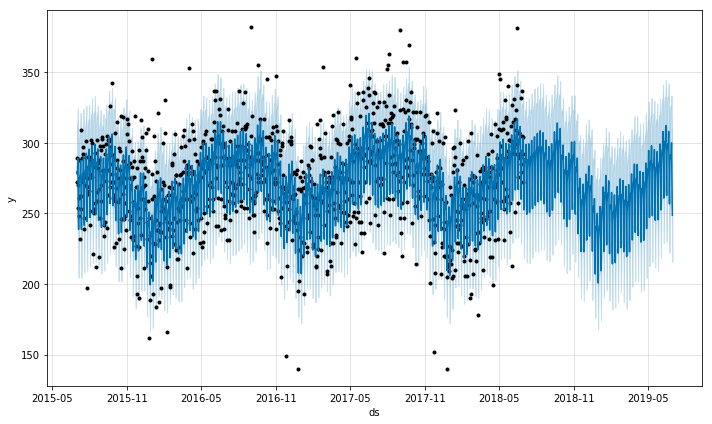

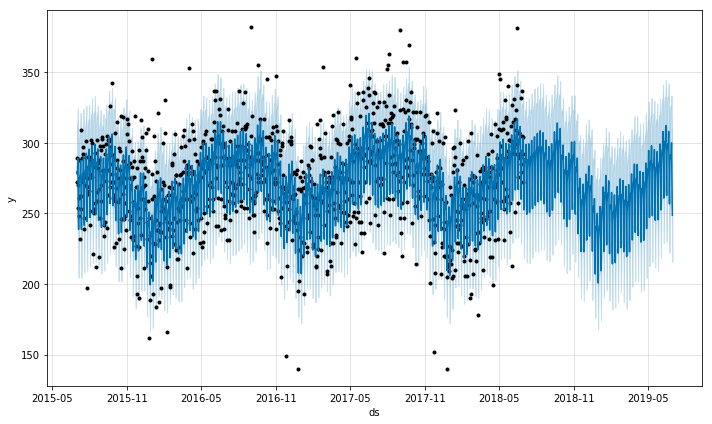

In [60]:
m.plot(forecast)

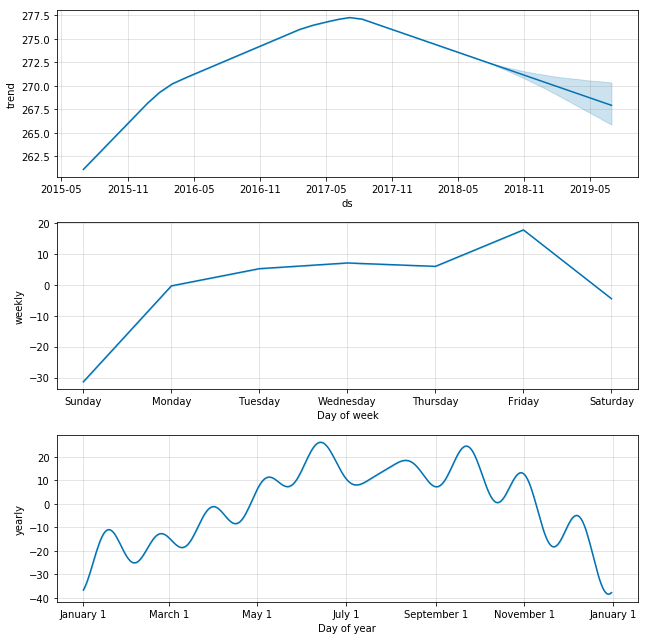

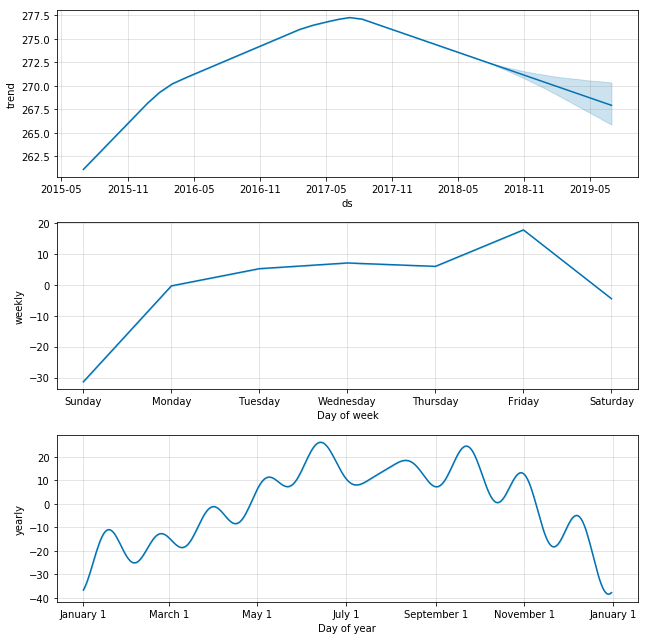

In [61]:
m.plot_components(forecast)

In [62]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [63]:
def make_comparison_dataframe(historical, forecast):
    '''
    join the history with the forecast.
    the resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper', and 'y'.
    '''
    return forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(historical.set_index('ds'))

In [64]:
cmp_df = make_comparison_dataframe(dailydf,forecast)
cmp_df.head()

yhat  yhat_lower  yhat_upper    y
ds                                                 
2015-07-01  279.428035  248.420362  314.114348  289
2015-07-02  277.589652  244.112079  310.359534  272
2015-07-03  288.758915  254.137974  324.500984  270
2015-07-04  265.971123  230.319189  298.331689  254
2015-07-05  238.663398  204.480765  274.370298  248

In [65]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 8.474084608220181
MAE 21.10792849471703


In [66]:
RMSE(cmp_df, prediction_size)

('Train RMSE 26.08651285622131', 'Test RMSE 27.22177847608037')

In [71]:
cmp_df.head()

yhat  yhat_lower  yhat_upper    y
ds                                                 
2015-07-01  279.428035  248.420362  314.114348  289
2015-07-02  277.589652  244.112079  310.359534  272
2015-07-03  288.758915  254.137974  324.500984  270
2015-07-04  265.971123  230.319189  298.331689  254
2015-07-05  238.663398  204.480765  274.370298  248

In [162]:
# cmp_df.reset_index(inplace=True)
cmp_df.head()

ds        yhat  yhat_lower  yhat_upper    y
0 2015-07-01  279.428035  248.420362  314.114348  289
1 2015-07-02  277.589652  244.112079  310.359534  272
2 2015-07-03  288.758915  254.137974  324.500984  270
3 2015-07-04  265.971123  230.319189  298.331689  254
4 2015-07-05  238.663398  204.480765  274.370298  248

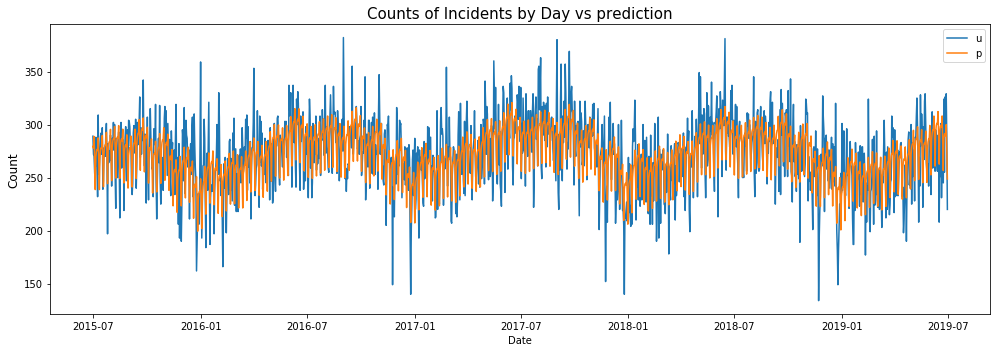

In [81]:
plt.figure(figsize=(14,5))
sns.lineplot(x='ds',y='y',data=cmp_df, label='actual')
sns.lineplot(x='ds', y='yhat', data=cmp_df, label='predicted')
plt.title('Counts of Incidents by Day vs prediction',size=15)
plt.ylabel('Count', size=12)
plt.xlabel('Date', )
plt.legend( 'upper right')
plt.tight_layout()
plt.savefig('img/act_pred.png')


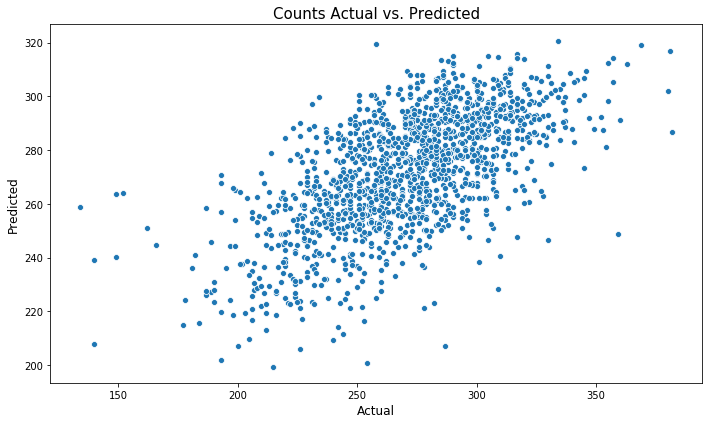

In [69]:
plt.figure(figsize=(10,6))
sns.scatterplot(cmp_df['y'],cmp_df['yhat'])
plt.title('Counts Actual vs. Predicted',size=15)
plt.ylabel('Predicted',size=12)
plt.xlabel('Actual',size=12)
plt.tight_layout()
plt.savefig('img/act_pred2.png')

In [ ]:
## that looks a little messy, lets break it down into weeks

In [169]:
cmp_df.head(3)

ds        yhat  yhat_lower  yhat_upper    y
0 2015-07-01  279.428035  248.420362  314.114348  289
1 2015-07-02  277.589652  244.112079  310.359534  272
2 2015-07-03  288.758915  254.137974  324.500984  270

In [175]:
# cmp_df_weekly = weeklyagg(cmp_df.reset_index().rename(columns={'ds':'date','index':'INCIDENT_NUMBER'}))

cmp_df_weekly = cmp_df.set_index('ds')
cmp_df_weekly = pd.DataFrame(cmp_df_weekly.resample('W').sum())
cmp_df_weekly.reset_index(inplace=True)
cmp_df_weekly.head(3)

ds         yhat   yhat_lower   yhat_upper     y
0 2015-07-05  1350.411124  1181.470369  1521.676851  1333
1 2015-07-12  1887.732853  1645.230799  2115.775747  1867
2 2015-07-19  1900.399614  1667.374659  2133.932840  1911

In [176]:
cmp_df_weekly.head()
print(np.mean(cmp_df_weekly.y))

1893.3062200956938


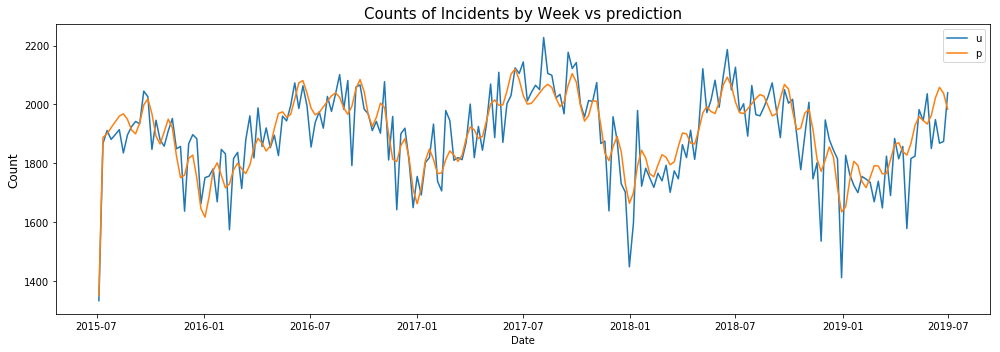

In [177]:
plt.figure(figsize=(14,5))
sns.lineplot(x='ds',y='y',data=cmp_df_weekly, label='actual')
sns.lineplot(x='ds', y='yhat', data=cmp_df_weekly, label='predicted')
plt.title('Counts of Incidents by Week vs prediction',size=15)
plt.ylabel('Count', size=12)
plt.xlabel('Date', )
plt.legend( 'upper right')
plt.tight_layout()
plt.savefig('img/act_pred_weekly.png')


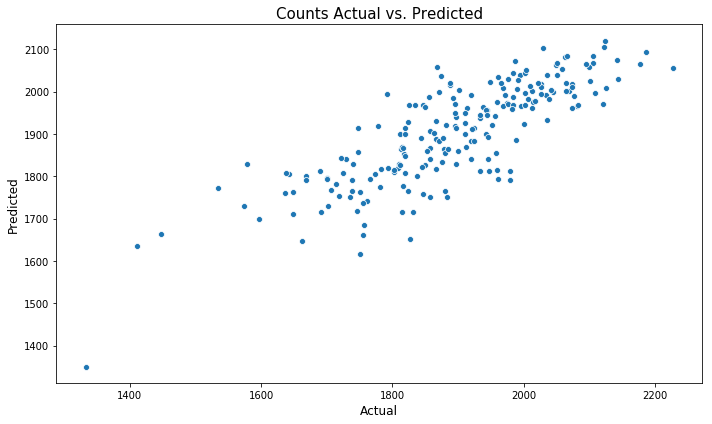

In [178]:
plt.figure(figsize=(10,6))
sns.scatterplot(cmp_df_weekly['y'],cmp_df_weekly['yhat'])
plt.title('Counts Actual vs. Predicted',size=15)
plt.ylabel('Predicted',size=12)
plt.xlabel('Actual',size=12)
plt.tight_layout()
plt.savefig('img/act_pred_weekly2.png')

In [182]:
for err_name, err_value in calculate_forecast_errors(cmp_df_weekly, 52).items():
    print(err_name, err_value)

MAPE 4.390534335292238
MAE 78.0929018375634


In [181]:
RMSE(cmp_df_weekly, 52)

('Train RMSE 78.13871914673202', 'Test RMSE 100.11461027817114')

In [ ]:
cmp_df_weekly = cmp_df.set_index('ds')
cmp_df_weekly = pd.DataFrame(cmp_df_weekly.resample('W').sum())
cmp_df_weekly.reset_index(inplace=True)
cmp_df_weekly.head(3)

## Shooting Analysis and Modeling

In [51]:
dfshoot = df[df.SHOOTING == 'Y']
dfshoot.DISTRICT.value_counts()

B2     552
B3     359
C11    269
D4     102
E13    100
C6      53
E18     52
A7      33
D14     29
E5      24
A1      21
A15      7
Name: DISTRICT, dtype: int64

In [52]:
dfshoot.head(3)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
5811      I192049778           413  Aggravated Assault   
6092      I192049465          2662          Ballistics   
6093      I192049465           413  Aggravated Assault   

                 OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
5811  ASSAULT - AGGRAVATED - BATTERY       B3            417        Y   
6092       BALLISTICS EVIDENCE/FOUND       B2            329        Y   
6093  ASSAULT - AGGRAVATED - BATTERY       B2            329        Y   

         OCCURRED_ON_DATE  YEAR MONTH DAY_OF_WEEK  HOUR  UCR_PART  \
5811  2019-06-30 00:26:00  2019   Jun      Sunday     0  Part One   
6092  2019-06-29 02:32:00  2019   Jun    Saturday     2  Part Two   
6093  2019-06-29 02:32:00  2019   Jun    Saturday     2  Part One   

           STREET        Lat       Long                     Location  \
5811  ROCKWELL ST  42.283391 -71.073886  (42.28339069, -71.07388628)   
6092     DEVON ST  42.309278 -71.078688  (42.30927790, -71.07868791)   
6093     DEVON ST  42.309278 -71.078688  (42.30927790, -71.07868791)   

            date      time  
5811  2019-06-30  00:26:00  
6092  2019-06-29  02:32:00  
6093  2019-06-29  02:32:00

In [54]:
dailyshoot = dfshoot[['date', 'INCIDENT_NUMBER']].groupby('date').count()
dailyshoot.reset_index(inplace=True)
dailyshoot.columns = ['ds', 'y']

In [55]:
dailyshoot.head(5)

ds   y
0  2015-07-01   1
1  2015-07-02  12
2  2015-07-04   7
3  2015-07-05   3
4  2015-07-06   2

In [56]:
dailyshoot[dailyshoot.y == max(dailyshoot.y)]

ds   y
374  2017-12-20  28

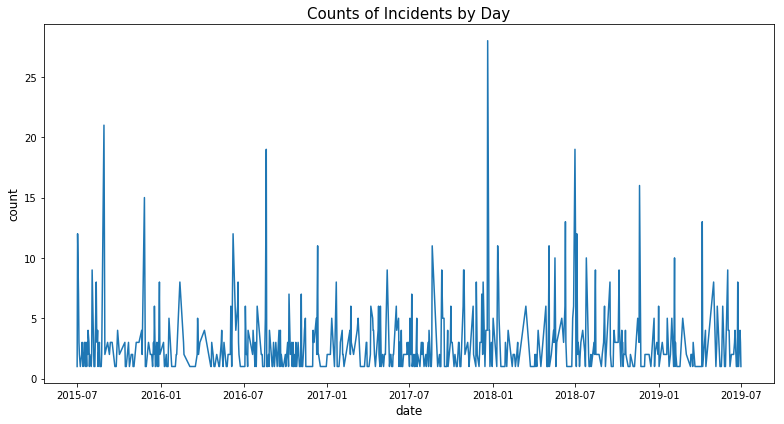

In [57]:
plt.figure(figsize=(11,6))
sns.lineplot(x='ds',y='y',data=dailyshoot)
plt.title('Counts of Incidents by Day',size=15)
plt.xlabel('date', size=12)
plt.ylabel('count', size=12)
plt.tight_layout()

In [58]:
weeklyshoot = dfshoot.set_index(pd.DatetimeIndex(dfshoot['date']))
weeklyshoot = pd.DataFrame(weeklyshoot.resample('W').count())
weeklyshoot = weeklyshoot.drop(['date'], axis=1)
weeklyshoot.reset_index(inplace=True)
weeklyshoot = weeklyshoot[['date', 'INCIDENT_NUMBER']]
weeklyshoot.columns = ['ds', 'y']
weeklyshoot.head()

ds   y
0 2015-07-05  23
1 2015-07-12   8
2 2015-07-19   9
3 2015-07-26  13
4 2015-08-02   9

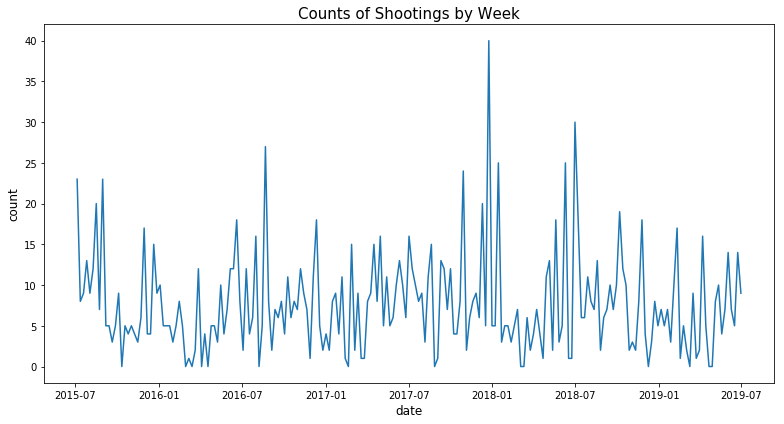

In [59]:
plt.figure(figsize=(11,6))
sns.lineplot(x='ds',y='y',data=weeklyshoot)
plt.title('Counts of Shootings by Week',size=15)
plt.xlabel('date', size=12)
plt.ylabel('count', size=12)
plt.tight_layout()

In [60]:
logging.getLogger().setLevel(logging.ERROR)

In [61]:
shoot_pred_size = 100
train_df_shoot = dailyshoot[:-shoot_pred_size]
train_df_shoot.tail(3)

ds  y
465  2018-09-05  1
466  2018-09-15  8
467  2018-09-16  2

In [62]:
m1 = Prophet()
m1.fit(train_df_shoot);

In [63]:
future1 = m1.make_future_dataframe(periods=shoot_pred_size)

In [64]:
future1.tail()

ds
563 2018-12-21
564 2018-12-22
565 2018-12-23
566 2018-12-24
567 2018-12-25

In [65]:
forecast1 = m1.predict(future1)
forecast1.tail(3)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
565 2018-12-23  3.382590    0.145684    7.386702     3.381200     3.383841   
566 2018-12-24  3.383553   -0.024548    7.466748     3.382137     3.384844   
567 2018-12-25  3.384516   -0.063432    7.319391     3.383082     3.385836   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
565        0.567022              0.567022              0.567022 -0.201921   
566        0.290379              0.290379              0.290379 -0.431098   
567        0.236281              0.236281              0.236281 -0.436055   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
565     -0.201921     -0.201921  0.768943      0.768943      0.768943   
566     -0.431098     -0.431098  0.721477      0.721477      0.721477   
567     -0.436055     -0.436055  0.672336      0.672336      0.672336   

     multiplicative_terms  multiplicative_terms_lower  \
565                   0.0                         0.0   
566                   0.0                         0.0   
567                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
565                         0.0  3.949611  
566                         0.0  3.673932  
567                         0.0  3.620798

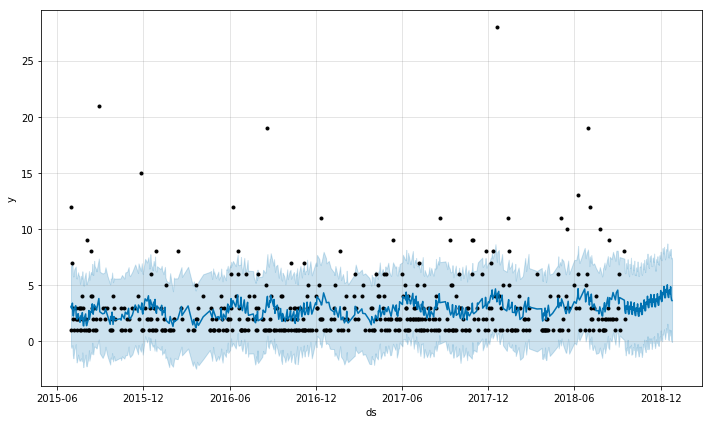

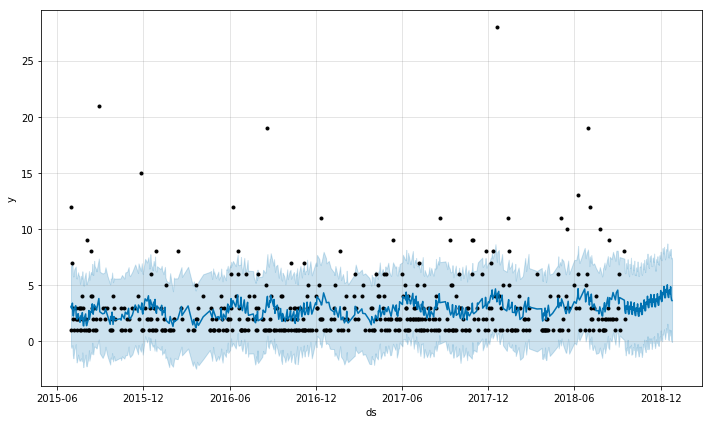

In [66]:
m1.plot(forecast1)

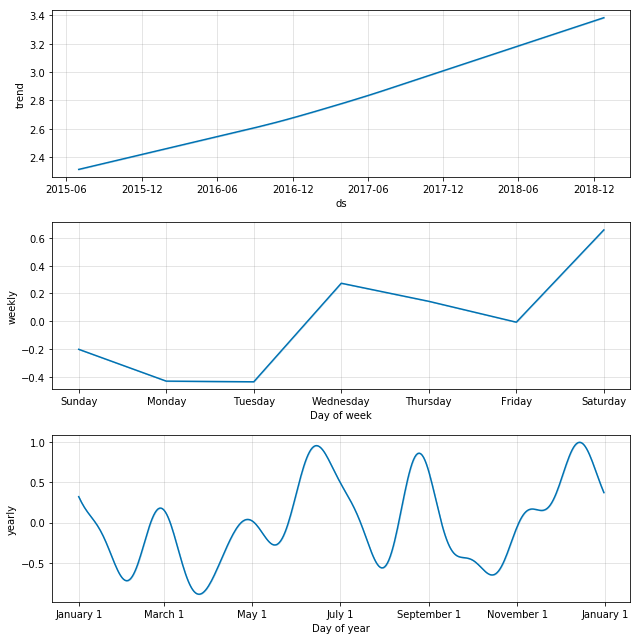

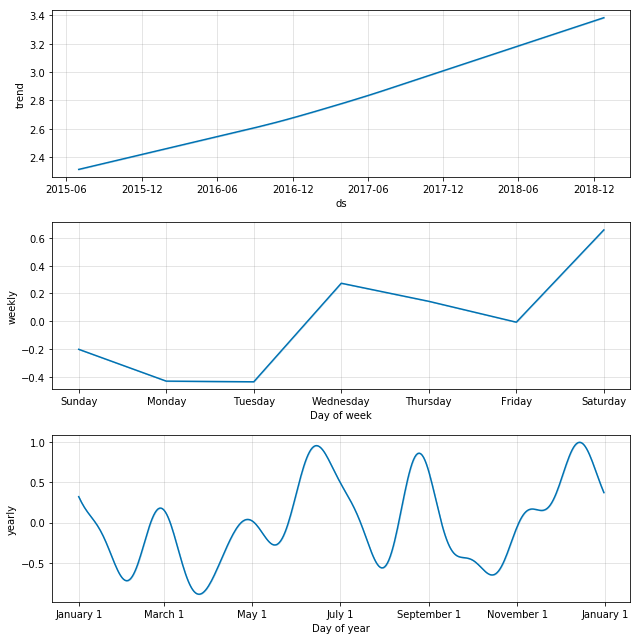

In [67]:
m1.plot_components(forecast1)

In [68]:
print(', '.join(forecast1.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [69]:
cmp_df1 = make_comparison_dataframe(dailyshoot,forecast1)

In [70]:
null_data = cmp_df1[cmp_df1.isnull().any(axis=1)]
null_data

yhat  yhat_lower  yhat_upper   y
ds                                              
2018-09-17  2.508404   -0.856953    6.054930 NaN
2018-09-21  2.869786   -0.817517    6.485698 NaN
2018-09-25  2.426584   -1.005422    5.794533 NaN
2018-09-27  3.003696   -0.591290    6.556800 NaN
2018-09-28  2.850901   -0.465951    6.555073 NaN
2018-09-30  2.645924   -1.204532    6.254365 NaN
2018-10-01  2.409052   -1.118063    5.967291 NaN
2018-10-02  2.394315   -1.142812    6.004162 NaN
2018-10-04  2.948529   -0.509123    6.409812 NaN
2018-10-08  2.307197   -1.391952    6.043374 NaN
2018-10-10  2.979451   -0.532439    6.500327 NaN
2018-10-16  2.234788   -1.331674    5.867325 NaN
2018-10-17  2.954024   -0.478536    6.628927 NaN
2018-10-21  2.567458   -1.001349    6.123034 NaN
2018-10-22  2.373068   -1.393195    5.919457 NaN
2018-10-23  2.407203   -1.177813    6.068702 NaN
2018-10-24  3.160027   -0.624591    6.953339 NaN
2018-10-26  2.973859   -0.479618    6.401198 NaN
2018-10-28  2.879260   -0.705760    6.568257 NaN
2018-10-31  3.503839    0.101686    7.343589 NaN
2018-11-01  3.419389   -0.033453    7.152560 NaN
2018-11-02  3.311784   -0.675403    6.902176 NaN
2018-11-03  4.015433    0.447431    7.814096 NaN
2018-11-04  3.190395   -0.408825    7.016900 NaN
2018-11-06  3.012550   -0.588989    6.531291 NaN
2018-11-07  3.743629    0.274454    7.446338 NaN
2018-11-09  3.491667   -0.163982    7.102618 NaN
2018-11-10  4.164293    0.258965    7.659051 NaN
2018-11-11  3.308767   -0.100170    6.704294 NaN
2018-11-12  3.081031   -0.679272    6.699972 NaN
2018-11-13  3.075206   -0.453870    6.698410 NaN
2018-11-14  3.782755    0.307461    7.435981 NaN
2018-11-16  3.495999   -0.133761    7.076606 NaN
2018-11-17  4.158453    0.452159    7.815429 NaN
2018-11-20  3.071295   -0.384659    6.274185 NaN
2018-11-21  3.790366    0.170007    7.128797 NaN
2018-11-23  3.541399   -0.161455    7.066490 NaN
2018-11-25  3.397198   -0.230775    6.864894 NaN
2018-11-26  3.201084   -0.398526    7.112359 NaN
2018-11-28  3.986194    0.297223    7.579477 NaN
2018-11-29  3.902174    0.446733    7.700239 NaN
2018-12-02  3.712002    0.134168    7.234203 NaN
2018-12-03  3.537551    0.233672    7.225288 NaN
2018-12-04  3.587242   -0.004871    7.365240 NaN
2018-12-05  4.350814    0.663204    8.300803 NaN
2018-12-06  4.272182    0.585040    8.030639 NaN
2018-12-07  4.170507    0.777862    7.811898 NaN
2018-12-08  4.879870    1.059820    8.416319 NaN
2018-12-09  4.059962    0.614394    7.698757 NaN
2018-12-11  3.888992    0.442571    7.486316 NaN
2018-12-12  4.620948    0.863228    8.054563 NaN
2018-12-13  4.505786    1.179015    8.223533 NaN
2018-12-15  5.028667    1.562690    8.714307 NaN
2018-12-16  4.162209    0.764720    7.924576 NaN
2018-12-17  3.919585    0.189736    7.487525 NaN
2018-12-18  3.894586    0.086893    7.450276 NaN
2018-12-19  4.578395    1.051635    7.948466 NaN
2018-12-20  4.416483    0.875171    8.119237 NaN
2018-12-24  3.673932   -0.024548    7.466748 NaN
2018-12-25  3.620798   -0.063432    7.319391 NaN

In [71]:
for err_name, err_value in calculate_forecast_errors(cmp_df1, shoot_pred_size).items():
    print(err_name, err_value)

MAPE 122.18680344214445
MAE 1.952226757283675


In [72]:
cmp_df1.reset_index(inplace=True)

In [73]:
cmp_df1.shape

(568, 5)

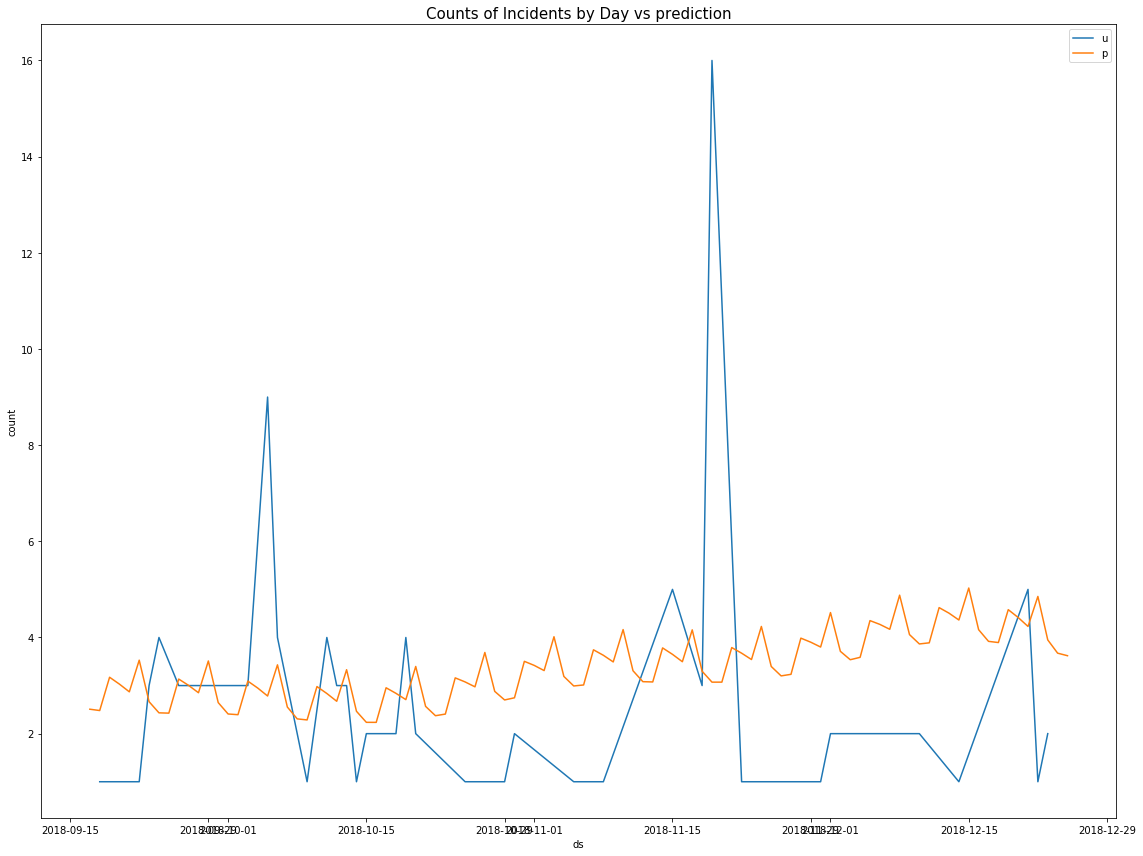

In [74]:
labels = ['actual', 'predicted']
plt.figure(figsize=(16,12))
sns.lineplot(x='ds',y='y',data=cmp_df1[-shoot_pred_size:], label='actual')
sns.lineplot(x='ds', y='yhat', data=cmp_df1[-shoot_pred_size:], label='predicted')
plt.title('Counts of Incidents by Day vs prediction',size=15)
plt.ylabel('count')
plt.legend( 'upper right')
plt.tight_layout()
# plt.savefig('img/act_pred.png')


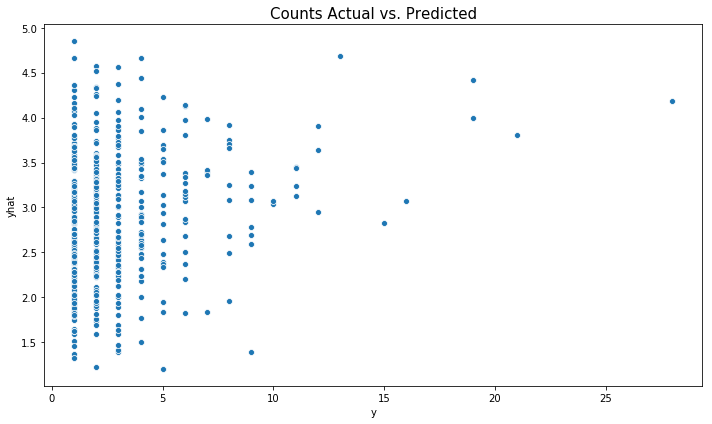

In [75]:
plt.figure(figsize=(10,6))
sns.scatterplot(cmp_df1['y'],cmp_df1['yhat'])
plt.title('Counts Actual vs. Predicted',size=15)
plt.tight_layout()
# plt.savefig('img/act_pred2.png')

## District Analysis and Prophet Predictions

#### B2

In [76]:
b2df = df[df['DISTRICT'] == 'B2']

In [77]:
b2df.head(3)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP OFFENSE_DESCRIPTION  \
1267      I192054685          3201       Property Lost     PROPERTY - LOST   
1511      I192054429          3115  Investigate Person  INVESTIGATE PERSON   
1552      I192054381          2629          Harassment          HARASSMENT   

     DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR MONTH  \
1267       B2            289      NaN  2019-06-07 00:00:00  2019   Jun   
1511       B2            612      NaN  2017-03-11 00:00:00  2017   Mar   
1552       B2            280      NaN  2019-01-01 11:48:00  2019   Jan   

     DAY_OF_WEEK  HOUR    UCR_PART         STREET        Lat       Long  \
1267      Friday     0  Part Three  SCHROEDER PLZ  42.333679 -71.091878   
1511    Saturday     0  Part Three     FRANCIS ST  42.336063 -71.107828   
1552     Tuesday    11    Part Two      DUDLEY ST  42.328836 -71.084598   

                         Location        date      time  
1267  (42.33367922, -71.09187755)  2019-06-07  00:00:00  
1511  (42.33606304, -71.10782832)  2017-03-11  00:00:00  
1552  (42.32883627, -71.08459849)  2019-01-01  11:48:00

In [78]:
b2daily = dailyagg(b2df)
b2daily.head()

ds   y
0 2015-07-01  37
1 2015-07-02  48
2 2015-07-03  53
3 2015-07-04  55
4 2015-07-05  48

In [79]:
b2weekly = weeklyagg(b2df)
b2weekly.head()

ds    y
0 2015-07-05  241
1 2015-07-12  306
2 2015-07-19  278
3 2015-07-26  304
4 2015-08-02  307

In [80]:
b2monthly = monthlyagg(b2df)
b2monthly.head()

ds     y
0 2015-07-31  1346
1 2015-08-31  1369
2 2015-09-30  1387
3 2015-10-31  1377
4 2015-11-30  1294

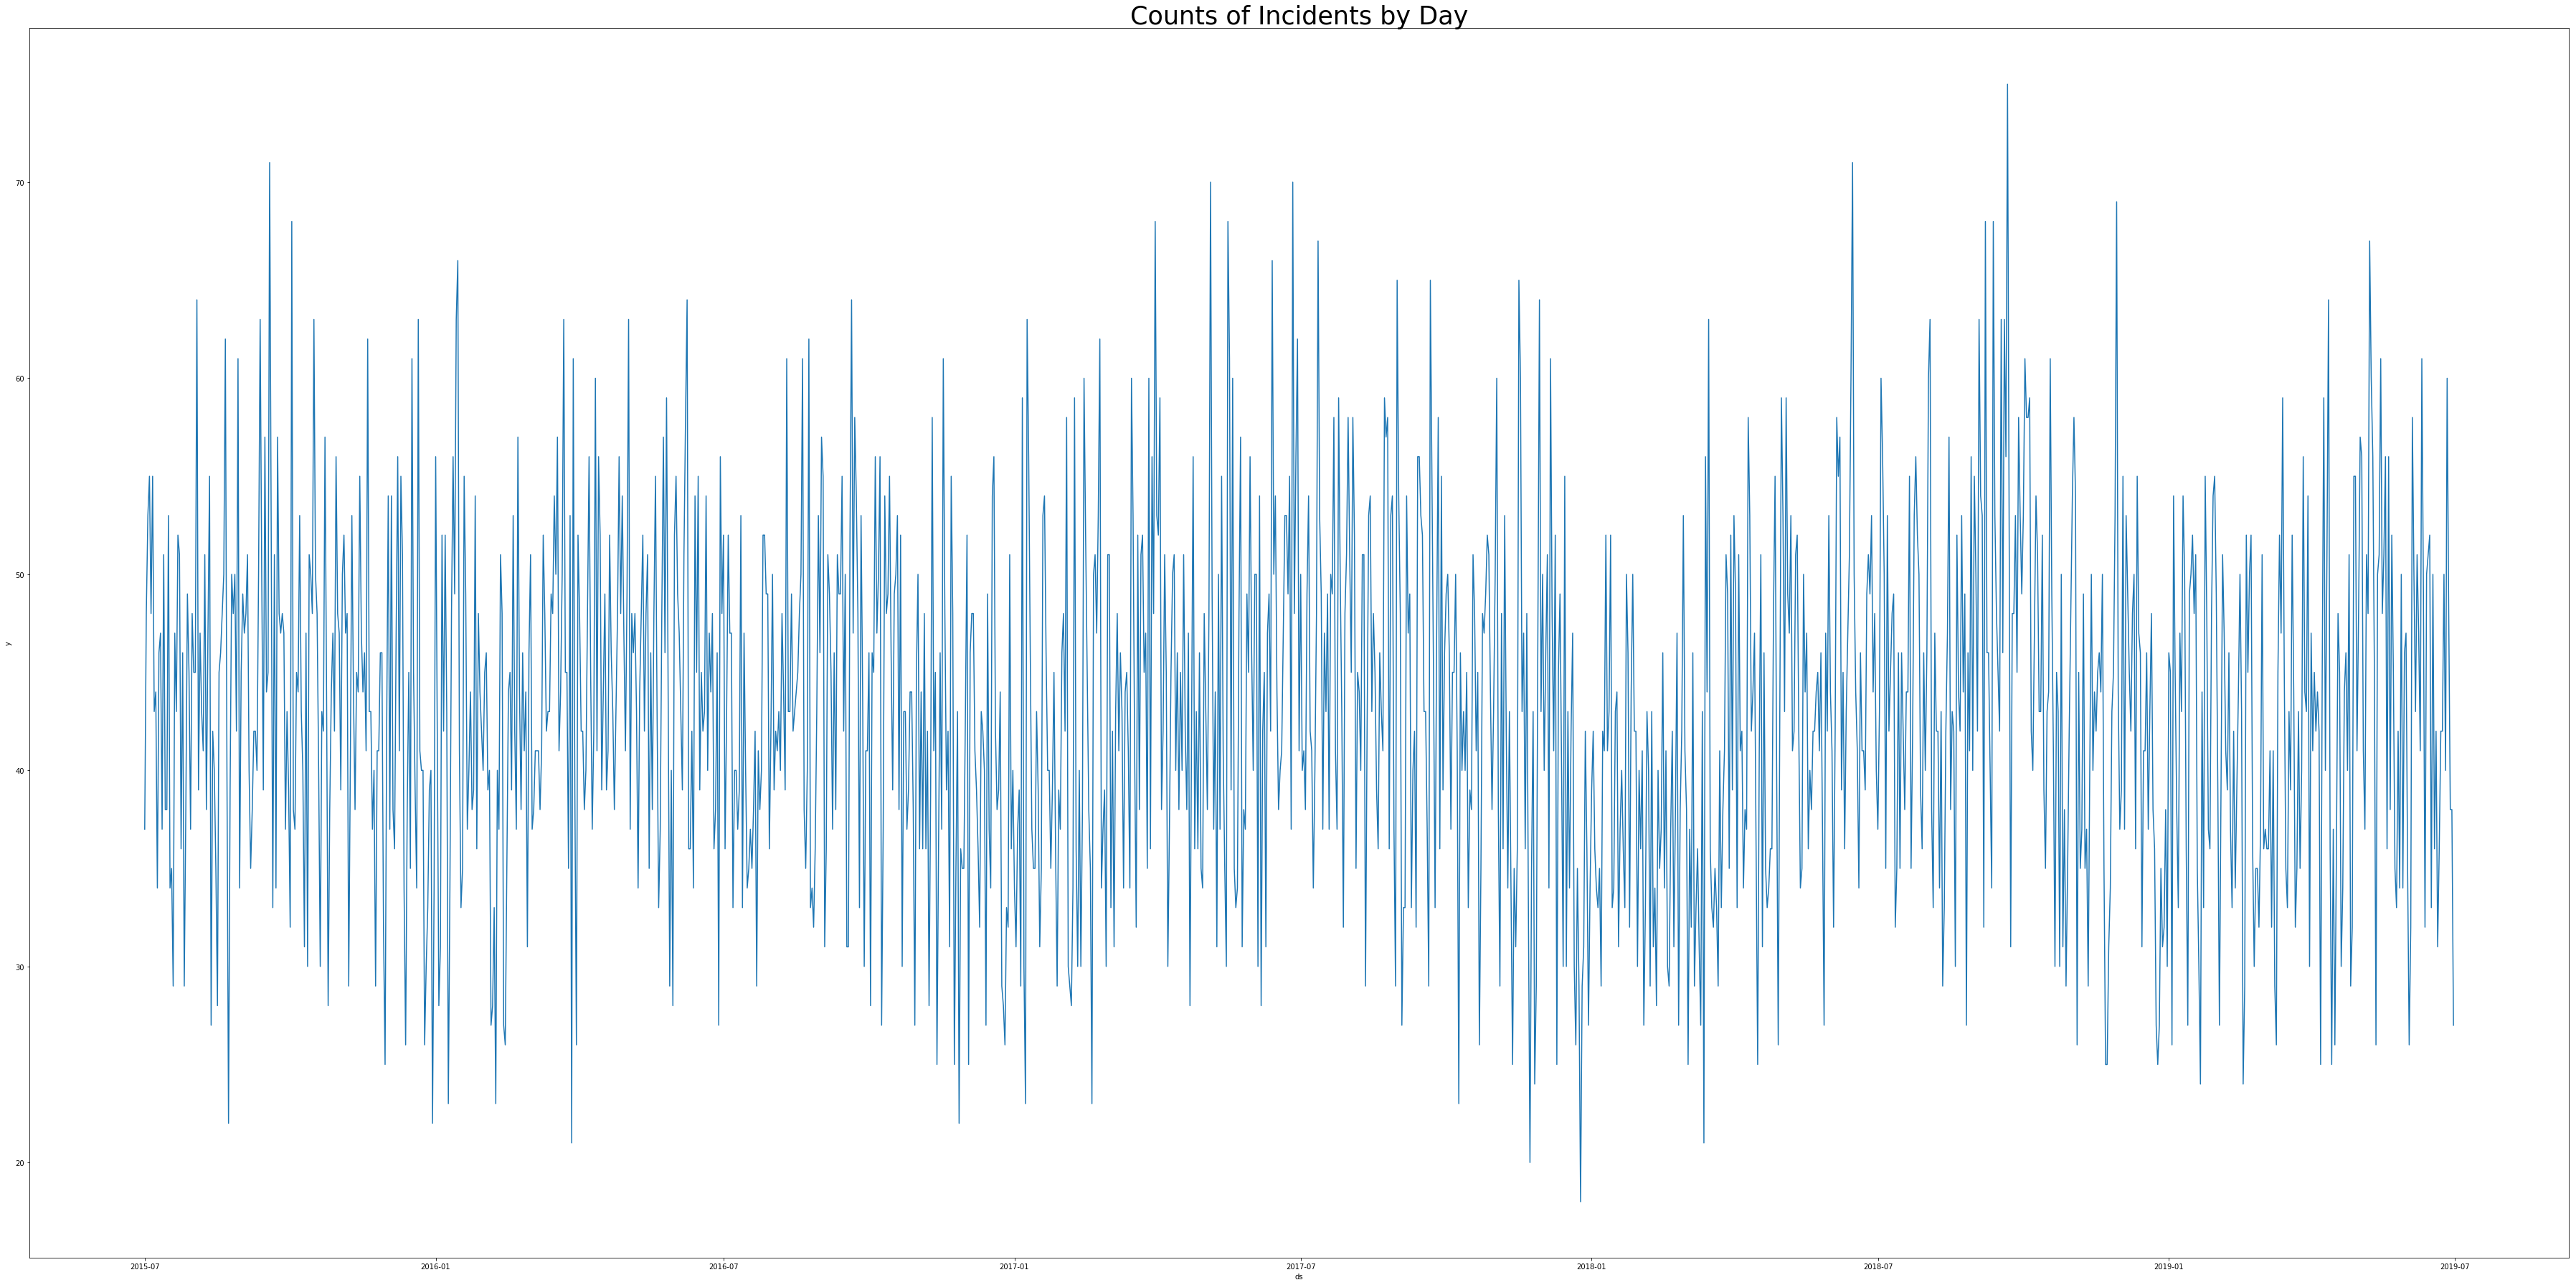

In [81]:
plt.figure(figsize=(50,25))
sns.lineplot(x='ds',y='y',data=b2daily)
plt.title('Counts of Incidents by Day',size=35)
plt.tight_layout()

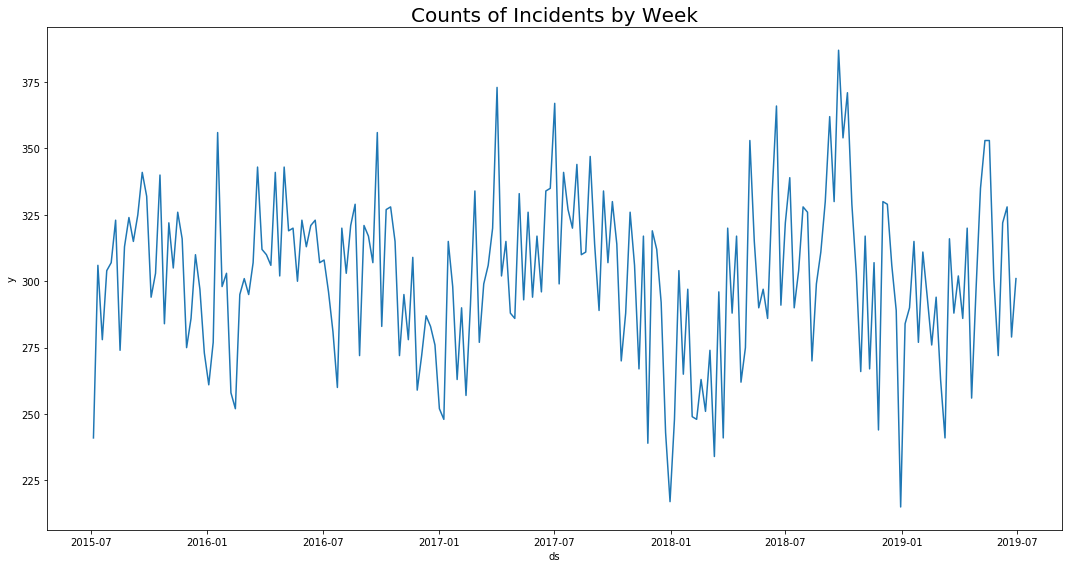

In [82]:
plt.figure(figsize=(15,8))
sns.lineplot(x='ds',y='y',data=b2weekly)
plt.title('Counts of Incidents by Week',size=20)
plt.tight_layout()

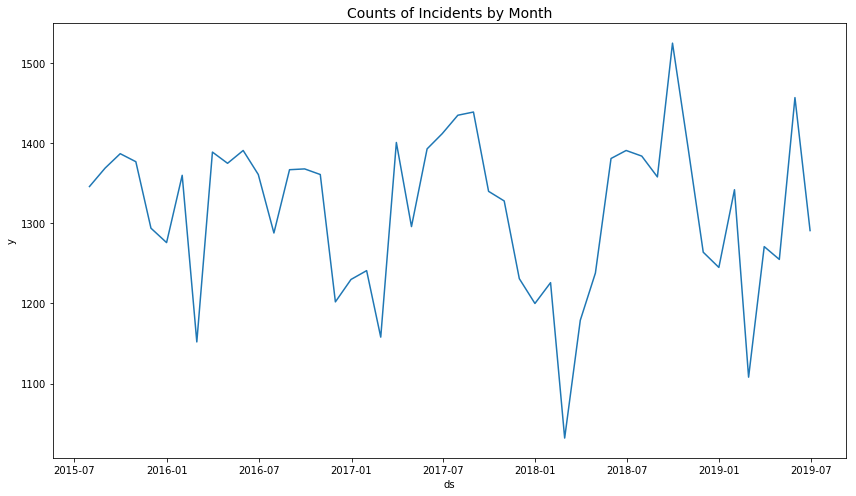

In [83]:
plt.figure(figsize=(12,7))
sns.lineplot(x='ds',y='y',data=b2monthly)
plt.title('Counts of Incidents by Month',size=14)
plt.tight_layout()

In [84]:
prediction_size = 365

In [85]:
b2train_df = b2daily[:-prediction_size]
b2train_df.tail(3)

ds   y
1093 2018-06-28  44
1094 2018-06-29  48
1095 2018-06-30  40

In [86]:
m2 = Prophet()
m2.fit(b2train_df);

In [87]:
future2 = m2.make_future_dataframe(periods=prediction_size)

In [88]:
forecast2 = m2.predict(future2)

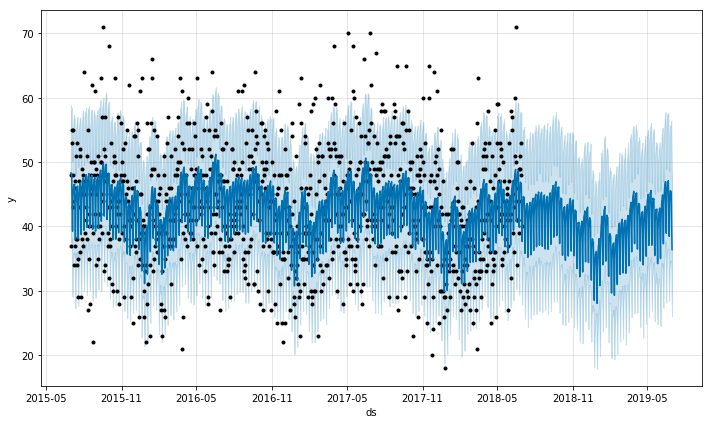

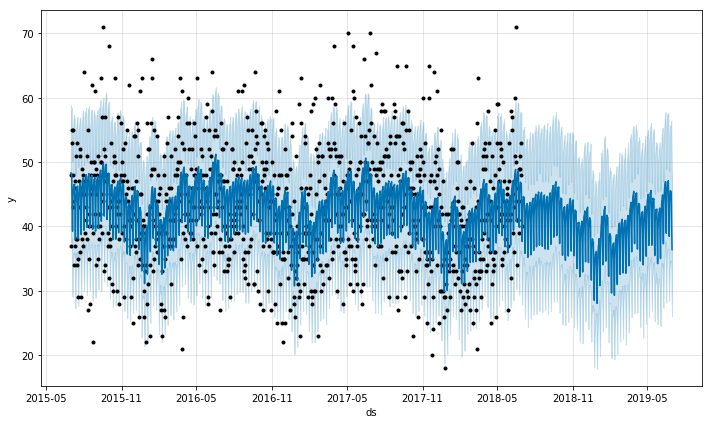

In [89]:
m2.plot(forecast2)

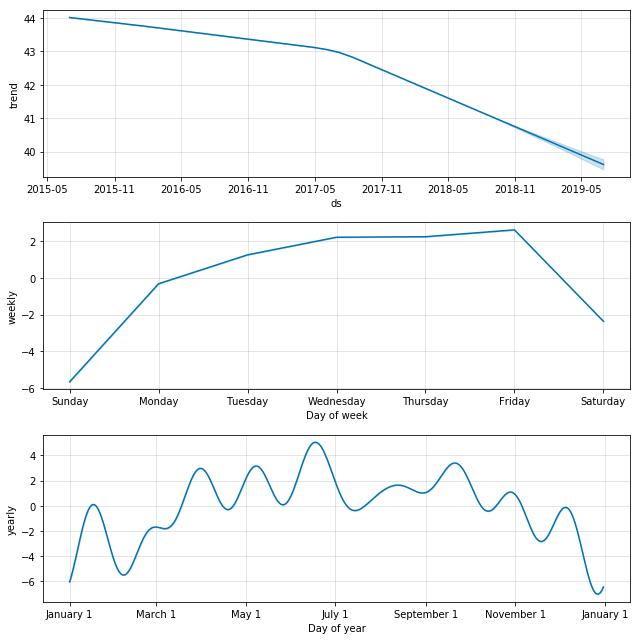

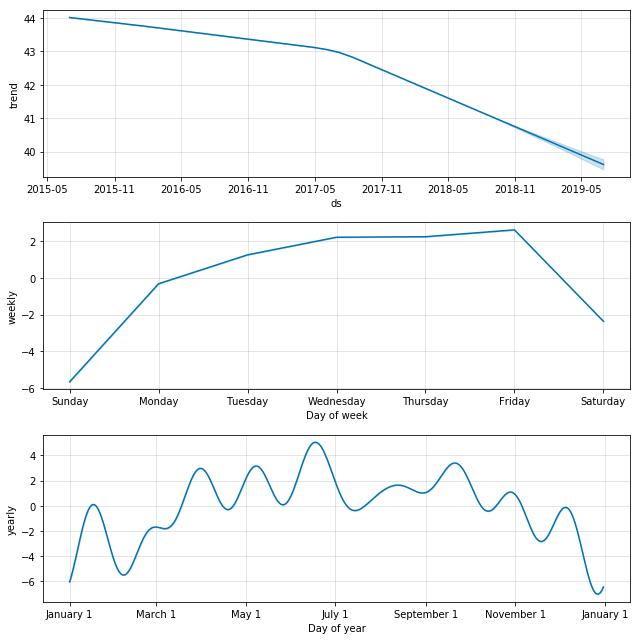

In [90]:
m2.plot_components(forecast2)

In [91]:
cmp_df2 = make_comparison_dataframe(b2daily, forecast2)

In [92]:
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 16.421679928485595
MAE 7.150753179601306


In [93]:
RMSE(cmp_df2, prediction_size)

('Train RMSE 8.131105261544858', 'Test RMSE 8.825063892870428')

## DBSCAN (Density Based Spacial Clustering of Applications with Noise) 

In [94]:
import cartopy
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)
import cartopy.crs as ccrs


In [95]:
df1 = df.drop(['SHOOTING'], axis=1)

In [96]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395701 entries, 37 to 405253
Data columns (total 18 columns):
INCIDENT_NUMBER        395701 non-null object
OFFENSE_CODE           395701 non-null int64
OFFENSE_CODE_GROUP     395701 non-null object
OFFENSE_DESCRIPTION    395701 non-null object
DISTRICT               393699 non-null object
REPORTING_AREA         395701 non-null object
OCCURRED_ON_DATE       395701 non-null object
YEAR                   395701 non-null int64
MONTH                  395701 non-null object
DAY_OF_WEEK            395701 non-null object
HOUR                   395701 non-null int64
UCR_PART               395595 non-null object
STREET                 383839 non-null object
Lat                    370586 non-null float64
Long                   370586 non-null float64
Location               395701 non-null object
date                   395701 non-null object
time                   395701 non-null object
dtypes: float64(2), int64(3), object(13)
memory usage: 67.4+ 

In [97]:
# drop observations that are missing Lat Lon coordinates (less than 1%) 
df1.dropna(inplace=True)

In [98]:
print(min(df1.Lat))
print(max(df1.Lat))
print(min(df1.Long))
print(max(df1.Long))

-1.0
42.39504158
-71.17867378
-1.0


In [99]:
len(df1.loc[df['Long']==-1])

194

In [100]:
len(df1.loc[df['Lat']==-1])

194

In [101]:
# df1 = df1[df1.Long != -1]
# df1 = df1[df1.Lat != -1]

In [102]:
# start_date = '2018-07-01'
# end_date = '2019-06-30'
# mask1 = (df1['date'] >= datetime.strptime(start_date, '%Y-%m-%d').date()) & (df1['date'] <= datetime.strptime(end_date, '%Y-%m-%d').date())
# df1 = df1[mask1]
# print(min(df['date']), max(df['date']))

2015-07-01 2019-06-30


In [ ]:
# db = DBSCAN(eps=0.3, min_samples=10).fit(df1[['Lat', 'Long']])

In [ ]:
# labels = db.labels_

In [ ]:
# print(labels[500:560])

In [115]:
llon = -72
ulon = -70
llat = 42
ulat = 43

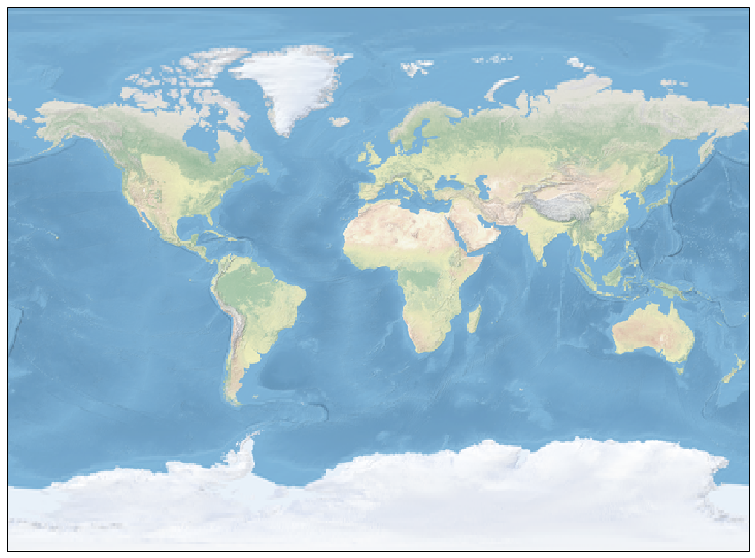

In [119]:
ax = plt.axes(projection=ccrs.Miller())
ax.stock_img()
# ax.set_extent([llon, ulon, llat, ulat])
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1, figsize)
def plot_time_series(day, week, month):
    

Text(0.5, 1.0, 'Counts of Incidents by Day')

AttributeError: 'AxesSubplot' object has no attribute 'lineplot'

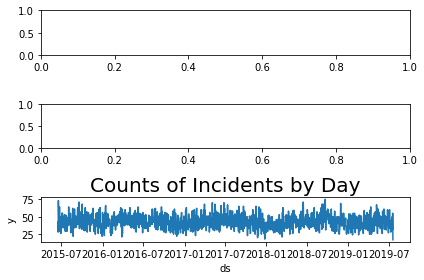

In [203]:
fig, ax = plt.subplots(3,1 )

# daily
ax[0] = sns.lineplot(x='ds',y='y',data=b2daily)
ax[0].set_title('Counts of Incidents by Day',size=20)
plt.tight_layout()

# weekly
ax[1].lineplot(x='ds',y='y',data=b2daily)
ax[1].set_title('Counts of Incidents by Day',size=20)
plt.tight_layout()
# monthly
ax[2].lineplot(x='ds',y='y',data=b2daily)
ax[2].set_title('Counts of Incidents by Day',size=20)
plt.tight_layout()

In [ ]:
# waffledistrict
fig = plt.figure(
    FigureClass=Waffle,
    rows=12,
    values= list(waffle['count']),
    labels= list(waffle['district']))